In this notebook i will follow the instructions in this video and adapt based on or proect and preferences : https://www.youtube.com/watch?v=p_6kULimQvI

In [17]:
pip install --upgrade matplotlib

In [18]:
!pip install -U numpy


  Using cached numpy-1.25.1-cp311-cp311-win_amd64.whl (15.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.25.1 which is incompatible.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.25.1 which is incompatible.


In [19]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install tensorflow

  Using cached numpy-1.24.3-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.


In [54]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import GRU, Dense

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt



In [23]:
# root_path = '../input/cs.csv' # local file
root_path = '..\cleaned-data\ethereum-pools-volume-cleaned.csv'

In [24]:
stock_df = pd.read_csv(root_path)
stock_df.head()

daily_volume                       time  total_volume            Pool-Name  \
0  8.568270e+04  2021-05-05T00:00:00+00:00  8.568270e+04  DAI / ETH 0.05% fee   
1  1.431467e+06  2021-05-06T00:00:00+00:00  1.517149e+06  DAI / ETH 0.05% fee   
2  8.459799e+06  2021-05-07T00:00:00+00:00  9.976948e+06  DAI / ETH 0.05% fee   
3  6.341874e+06  2021-05-08T00:00:00+00:00  1.631882e+07  DAI / ETH 0.05% fee   
4  2.707201e+05  2021-05-09T00:00:00+00:00  1.658954e+07  DAI / ETH 0.05% fee   

   running_total_by_pool  
0           8.568270e+04  
1           1.517149e+06  
2           9.976948e+06  
3           1.631882e+07  
4           1.658954e+07

In [25]:
stock_df = stock_df.rename(columns={'Pool-Name': 'pool_name'})
stock_df.head()

daily_volume                       time  total_volume            pool_name  \
0  8.568270e+04  2021-05-05T00:00:00+00:00  8.568270e+04  DAI / ETH 0.05% fee   
1  1.431467e+06  2021-05-06T00:00:00+00:00  1.517149e+06  DAI / ETH 0.05% fee   
2  8.459799e+06  2021-05-07T00:00:00+00:00  9.976948e+06  DAI / ETH 0.05% fee   
3  6.341874e+06  2021-05-08T00:00:00+00:00  1.631882e+07  DAI / ETH 0.05% fee   
4  2.707201e+05  2021-05-09T00:00:00+00:00  1.658954e+07  DAI / ETH 0.05% fee   

   running_total_by_pool  
0           8.568270e+04  
1           1.517149e+06  
2           9.976948e+06  
3           1.631882e+07  
4           1.658954e+07

In [26]:
# Loading the data
dataset = pd.read_csv('..\cleaned-data\ethereum-pools-volume-cleaned.csv')

In [27]:
# Split column 'Pool-Name' into three columns: 'Token_1', 'Token_2' and 'Fee's'
crypto_info = dataset['Pool-Name'].str.split(' ', n=2, expand=True)
dataset['Token_1'] = crypto_info[0]
dataset['Token_2'] = crypto_info[2].str.split(' ', n=1, expand=True)[0]

# Create columns for each rate type
dataset['fee_0.01%'] = 0
dataset['fee_0.05%'] = 0
dataset['fee_0.3%'] = 0
dataset['fee_1%'] = 0

# Assign the correct values to the fee columns
dataset.loc[dataset['Pool-Name'].str.contains('0.01%'), 'fee_0.01%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.05%'), 'fee_0.05%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.3%'), 'fee_0.3%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('1%'), 'fee_1%'] = 1

# printing to see the results
dataset

daily_volume                       time  total_volume  \
0      8.568270e+04  2021-05-05T00:00:00+00:00  8.568270e+04   
1      1.431467e+06  2021-05-06T00:00:00+00:00  1.517149e+06   
2      8.459799e+06  2021-05-07T00:00:00+00:00  9.976948e+06   
3      6.341874e+06  2021-05-08T00:00:00+00:00  1.631882e+07   
4      2.707201e+05  2021-05-09T00:00:00+00:00  1.658954e+07   
...             ...                        ...           ...   
15043  1.432193e+08  2023-05-22T00:00:00+00:00  3.750031e+11   
15044  1.514438e+08  2023-05-23T00:00:00+00:00  3.751546e+11   
15045  1.956226e+08  2023-05-24T00:00:00+00:00  3.753502e+11   
15046  1.432230e+08  2023-05-25T00:00:00+00:00  3.754934e+11   
15047  1.153192e+08  2023-05-26T00:00:00+00:00  3.756087e+11   

                  Pool-Name  running_total_by_pool Token_1 Token_2  fee_0.01%  \
0       DAI / ETH 0.05% fee           8.568270e+04     DAI     ETH          0   
1       DAI / ETH 0.05% fee           1.517149e+06     DAI     ETH          0   
2       DAI / ETH 0.05% fee           9.976948e+06     DAI     ETH          0   
3       DAI / ETH 0.05% fee           1.631882e+07     DAI     ETH          0   
4       DAI / ETH 0.05% fee           1.658954e+07     DAI     ETH          0   
...                     ...                    ...     ...     ...        ...   
15043  ETH / USDC 0.05% fee           3.750031e+11     ETH    USDC          0   
15044  ETH / USDC 0.05% fee           3.751546e+11     ETH    USDC          0   
15045  ETH / USDC 0.05% fee           3.753502e+11     ETH    USDC          0   
15046  ETH / USDC 0.05% fee           3.754934e+11     ETH    USDC          0   
15047  ETH / USDC 0.05% fee           3.756087e+11     ETH    USDC          0   

       fee_0.05%  fee_0.3%  fee_1%  
0              1         0       0  
1              1         0       0  
2              1         0       0  
3              1         0       0  
4              1         0       0  
...          ...       ...     ...  
15043          1         0       0  
15044          1         0       0  
15045          1         0       0  
15046          1         0       0  
15047          1         0       0  

[15048 rows x 11 columns]

In [28]:
# Save the new DataFrame to a CSV file
dataset.to_csv('new_dataset.csv', index=False)

In [29]:
# Token-to-number mapping dictionary
token_dict = {'DAI': 0, 'ETH': 1, 'LUSD': 2, 'USDC': 3, 'UDT': 4, 'MATIC': 5, 'WBTC': 6, 'USDT': 7, 'LINK': 8, 'OP': 9, 'ARB': 10, 'WETH': 11, 'BUSD': 12, 'BNB': 13}

# Mapping tokens to numbers in column 'Token_1'
dataset['Token_1'] = dataset['Token_1'].map(token_dict)

# Mapping tokens to numbers in column 'Token_2'
dataset['Token_2'] = dataset['Token_2'].map(token_dict)

dataset


daily_volume                       time  total_volume  \
0      8.568270e+04  2021-05-05T00:00:00+00:00  8.568270e+04   
1      1.431467e+06  2021-05-06T00:00:00+00:00  1.517149e+06   
2      8.459799e+06  2021-05-07T00:00:00+00:00  9.976948e+06   
3      6.341874e+06  2021-05-08T00:00:00+00:00  1.631882e+07   
4      2.707201e+05  2021-05-09T00:00:00+00:00  1.658954e+07   
...             ...                        ...           ...   
15043  1.432193e+08  2023-05-22T00:00:00+00:00  3.750031e+11   
15044  1.514438e+08  2023-05-23T00:00:00+00:00  3.751546e+11   
15045  1.956226e+08  2023-05-24T00:00:00+00:00  3.753502e+11   
15046  1.432230e+08  2023-05-25T00:00:00+00:00  3.754934e+11   
15047  1.153192e+08  2023-05-26T00:00:00+00:00  3.756087e+11   

                  Pool-Name  running_total_by_pool  Token_1  Token_2  \
0       DAI / ETH 0.05% fee           8.568270e+04        0        1   
1       DAI / ETH 0.05% fee           1.517149e+06        0        1   
2       DAI / ETH 0.05% fee           9.976948e+06        0        1   
3       DAI / ETH 0.05% fee           1.631882e+07        0        1   
4       DAI / ETH 0.05% fee           1.658954e+07        0        1   
...                     ...                    ...      ...      ...   
15043  ETH / USDC 0.05% fee           3.750031e+11        1        3   
15044  ETH / USDC 0.05% fee           3.751546e+11        1        3   
15045  ETH / USDC 0.05% fee           3.753502e+11        1        3   
15046  ETH / USDC 0.05% fee           3.754934e+11        1        3   
15047  ETH / USDC 0.05% fee           3.756087e+11        1        3   

       fee_0.01%  fee_0.05%  fee_0.3%  fee_1%  
0              0          1         0       0  
1              0          1         0       0  
2              0          1         0       0  
3              0          1         0       0  
4              0          1         0       0  
...          ...        ...       ...     ...  
15043          0          1         0       0  
15044          0          1         0       0  
15045          0          1         0       0  
15046          0          1         0       0  
15047          0          1         0       0  

[15048 rows x 11 columns]

In [30]:
# Removing the column 'Pool-Name' because the infos are now splited
dataset = dataset.drop(columns=['Pool-Name'])
dataset

daily_volume                       time  total_volume  \
0      8.568270e+04  2021-05-05T00:00:00+00:00  8.568270e+04   
1      1.431467e+06  2021-05-06T00:00:00+00:00  1.517149e+06   
2      8.459799e+06  2021-05-07T00:00:00+00:00  9.976948e+06   
3      6.341874e+06  2021-05-08T00:00:00+00:00  1.631882e+07   
4      2.707201e+05  2021-05-09T00:00:00+00:00  1.658954e+07   
...             ...                        ...           ...   
15043  1.432193e+08  2023-05-22T00:00:00+00:00  3.750031e+11   
15044  1.514438e+08  2023-05-23T00:00:00+00:00  3.751546e+11   
15045  1.956226e+08  2023-05-24T00:00:00+00:00  3.753502e+11   
15046  1.432230e+08  2023-05-25T00:00:00+00:00  3.754934e+11   
15047  1.153192e+08  2023-05-26T00:00:00+00:00  3.756087e+11   

       running_total_by_pool  Token_1  Token_2  fee_0.01%  fee_0.05%  \
0               8.568270e+04        0        1          0          1   
1               1.517149e+06        0        1          0          1   
2               9.976948e+06        0        1          0          1   
3               1.631882e+07        0        1          0          1   
4               1.658954e+07        0        1          0          1   
...                      ...      ...      ...        ...        ...   
15043           3.750031e+11        1        3          0          1   
15044           3.751546e+11        1        3          0          1   
15045           3.753502e+11        1        3          0          1   
15046           3.754934e+11        1        3          0          1   
15047           3.756087e+11        1        3          0          1   

       fee_0.3%  fee_1%  
0             0       0  
1             0       0  
2             0       0  
3             0       0  
4             0       0  
...         ...     ...  
15043         0       0  
15044         0       0  
15045         0       0  
15046         0       0  
15047         0       0  

[15048 rows x 10 columns]

In [31]:
# Convert 'time' column to datetime format
dataset['time'] = pd.to_datetime(dataset['time'])

# Set 'time' column as the index of the DataFrame
dataset.set_index('time', inplace=True)
dataset

daily_volume  total_volume  running_total_by_pool  \
time                                                                           
2021-05-05 00:00:00+00:00  8.568270e+04  8.568270e+04           8.568270e+04   
2021-05-06 00:00:00+00:00  1.431467e+06  1.517149e+06           1.517149e+06   
2021-05-07 00:00:00+00:00  8.459799e+06  9.976948e+06           9.976948e+06   
2021-05-08 00:00:00+00:00  6.341874e+06  1.631882e+07           1.631882e+07   
2021-05-09 00:00:00+00:00  2.707201e+05  1.658954e+07           1.658954e+07   
...                                 ...           ...                    ...   
2023-05-22 00:00:00+00:00  1.432193e+08  3.750031e+11           3.750031e+11   
2023-05-23 00:00:00+00:00  1.514438e+08  3.751546e+11           3.751546e+11   
2023-05-24 00:00:00+00:00  1.956226e+08  3.753502e+11           3.753502e+11   
2023-05-25 00:00:00+00:00  1.432230e+08  3.754934e+11           3.754934e+11   
2023-05-26 00:00:00+00:00  1.153192e+08  3.756087e+11           3.756087e+11   

                           Token_1  Token_2  fee_0.01%  fee_0.05%  fee_0.3%  \
time                                                                          
2021-05-05 00:00:00+00:00        0        1          0          1         0   
2021-05-06 00:00:00+00:00        0        1          0          1         0   
2021-05-07 00:00:00+00:00        0        1          0          1         0   
2021-05-08 00:00:00+00:00        0        1          0          1         0   
2021-05-09 00:00:00+00:00        0        1          0          1         0   
...                            ...      ...        ...        ...       ...   
2023-05-22 00:00:00+00:00        1        3          0          1         0   
2023-05-23 00:00:00+00:00        1        3          0          1         0   
2023-05-24 00:00:00+00:00        1        3          0          1         0   
2023-05-25 00:00:00+00:00        1        3          0          1         0   
2023-05-26 00:00:00+00:00        1        3          0          1         0   

                           fee_1%  
time                               
2021-05-05 00:00:00+00:00       0  
2021-05-06 00:00:00+00:00       0  
2021-05-07 00:00:00+00:00       0  
2021-05-08 00:00:00+00:00       0  
2021-05-09 00:00:00+00:00       0  
...                           ...  
2023-05-22 00:00:00+00:00       0  
2023-05-23 00:00:00+00:00       0  
2023-05-24 00:00:00+00:00       0  
2023-05-25 00:00:00+00:00       0  
2023-05-26 00:00:00+00:00       0  

[15048 rows x 9 columns]

In [32]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Print the normalized data
print(scaled_data)

[[2.65789325e-05 2.28026061e-07 2.28026061e-07 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44049152e-04 4.03908420e-06 4.03908420e-06 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.62427965e-03 2.65619867e-05 2.65619867e-05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.06832882e-02 9.99311671e-01 9.99311671e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44286309e-02 9.99692980e-01 9.99692980e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.57727157e-02 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [33]:
# Determine the split point for 80% of the data
split_point = int(len(scaled_data) * 0.6)

# Split the data into training and test sets
train, test = scaled_data[:split_point], scaled_data[split_point:]


# Print the number of items in each set
print('Training set: ', len(train))
print('Test set: ', len(test))

Training set:  9028
Test set:  6020


In [34]:
# Set the length of the sequence
seq_length = 10

# Function to create time sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create time sequences for training
X_train, y_train = create_sequences(train, seq_length)
# Create time sequences for testing
X_test, y_test = create_sequences(test, seq_length)

In [35]:
# Defines the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))

# Compiles the template
model.compile(optimizer='adam', loss='mse')

# Displays the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 50)            9150      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 24501 (95.71 KB)
Trainable params: 24501 (95.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)



# Get the model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Adjust the dimensions of y_train and y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


Epoch 1/100
141/141 [==============================] - 3s 5ms/step - loss: 0.1399
Epoch 2/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 4/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 5/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 7/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 8/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 9/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 10/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 11/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 12/100
141/141 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 13/100


In [37]:
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Number of samples in X_train: 9018
Number of samples in y_train: 81162


In [38]:
# Resize y_train to have the same number of samples as X_train
y_train = y_train[:X_train.shape[0]]

# Verify again
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Number of samples in X_train: 9018
Number of samples in y_train: 9018


Epoch 1/100
141/141 [==============================] - 2s 5ms/step - loss: 0.0984
Epoch 2/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0979
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0980
Epoch 4/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0979
Epoch 5/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0978
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0978
Epoch 7/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0978
Epoch 8/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0977
Epoch 9/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0977
Epoch 10/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0977
Epoch 11/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0977
Epoch 12/100
141/141 [==============================] - 1s 5ms/step - loss: 0.0977
Epoch 13/100


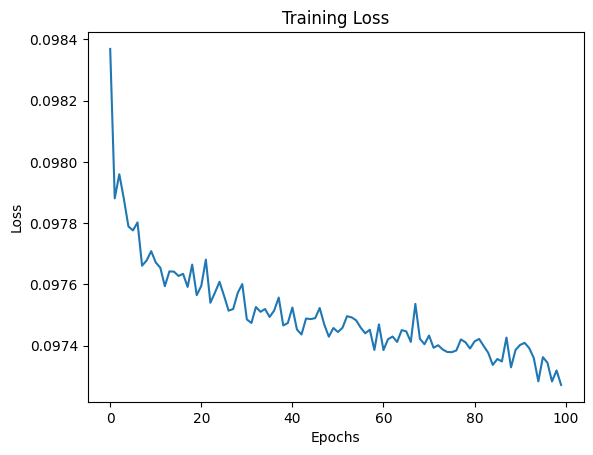

In [39]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The "epoch" represents a complete iteration of the training data, the "training loss" is the metric that quantifies the error during training, and the "loss" graph shows the variation of the loss over epochs.

In [40]:
# Get model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reshape the dimensions of y_train and y_test arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Resize train_predictions
train_predictions = train_predictions[:len(y_train)]

# Resize test_predictions
test_predictions = test_predictions[:len(y_test)]

# Resize y_train to have the same number of samples as train_predictions
y_train = y_train[:len(train_predictions)]

# Resize y_test to have the same number of samples as test_predictions
y_test = y_test[:len(test_predictions)]

# Verify shapes
print(y_test.shape)
print(test_predictions.shape)



188/188 [==============================] - 0s 2ms/step
(6010, 1)
(6010, 1)


This means that you have 3000 samples for both y_test (actual values) and test_predictions (values predicted by the model). These dimensions are consistent and suitable for calculating error metrics.

Therefore, you can proceed to use the calculated values of train_mae, train_mse, test_mae, and test_mse to evaluate your model's performance in terms of Mean Absolute Error (MAE) and Mean Squared Error (MSE).

"(3000, 1)" indicates the shape of the arrays y_test and test_predictions. Both have 3000 samples and 1 dimension.

# Model Evaluation Metrics

Mean Absolute Error (MAE): The mean absolute error measures the average of absolute differences between predictions and actual values. A lower MAE value indicates better model performance.


Mean Squared Error (MSE): The mean squared error measures the average of the squares of the differences between predictions and actual values. It is a widely used metric that penalizes larger errors more heavily than MAE.

In [41]:
# Calculate training set errors
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)


In [42]:
# Calculate test set errors
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

In [58]:
# Printing test and train
print(train_mae)
print(test_mae)
print(train_mse) 
print(test_mse)

In [44]:
print("train_mae:", train_mae)
print("test_mae:", test_mae)
print("train_mse:", train_mse)
print("test_mse:", test_mse)


train_mae: 0.20436774259141594
test_mae: 0.2655260707164521
train_mse: 0.09713578629109638
test_mse: 0.16532789179034743


In [45]:
print("train_mae type:", type(train_mae))
print("test_mae type:", type(test_mae))
print("train_mse type:", type(train_mse))
print("test_mse type:", type(test_mse))


train_mae type: <class 'numpy.float64'>
test_mae type: <class 'numpy.float64'>
train_mse type: <class 'numpy.float64'>
test_mse type: <class 'numpy.float64'>


In [46]:
train_mae = [train_mae]  # Convert to list
test_mae = [test_mae]  # Convert to list
train_mse = [train_mse]  # Convert to list
test_mse = [test_mse]  # Convert to list

In [47]:
# Priting to see if now they are a list
print("train_mae type:", type(train_mae))
print("test_mae type:", type(test_mae))
print("train_mse type:", type(train_mse))
print("test_mse type:", type(test_mse))


train_mae type: <class 'list'>
test_mae type: <class 'list'>
train_mse type: <class 'list'>
test_mse type: <class 'list'>


In [48]:
# Definition of the calculate_mae function

def calculate_mae(predictions, labels):
    return np.mean(np.abs(predictions - labels))

# Definition of the calculate_mse function
def calculate_mse(predictions, labels):
    return np.mean(np.square(predictions - labels))

train_data = X_train  # Replace X_train with your training data
train_labels = y_train  # Replace y_train with your training labels
test_data = X_test  # Replace X_test with your test data
test_labels = y_test  # Replace y_test with your test labels

num_epochs = 10

train_mae = []
test_mae = []
train_mse = []
test_mse = []

# Model training loop
for epoch in range(num_epochs):
      # Model training
    model.fit(train_data, train_labels)
    
    # Model evaluation
    train_predictions = model.predict(train_data)
    test_predictions = model.predict(test_data)
    
    # Calculation of MAE and MSE
    train_mae_value = calculate_mae(train_predictions, train_labels)
    test_mae_value = calculate_mae(test_predictions, test_labels)
    train_mse_value = calculate_mse(train_predictions, train_labels)
    test_mse_value = calculate_mse(test_predictions, test_labels)

    # Update of MAE and MSE values
    train_mae.append(train_mae_value)
    test_mae.append(test_mae_value)
    train_mse.append(train_mse_value)
    test_mse.append(test_mse_value)


188/188 [==============================] - 0s 2ms/step


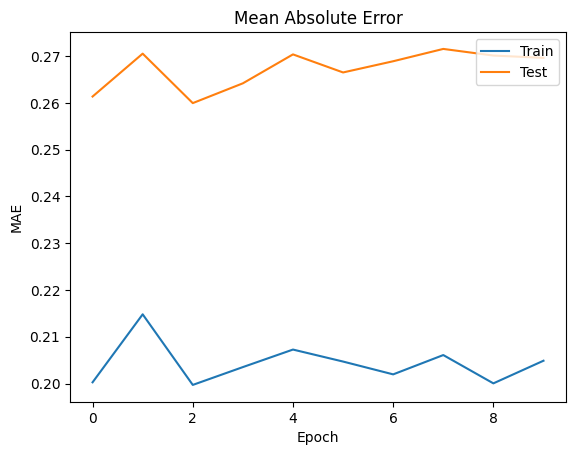

In [49]:
# Plot training and test MAE
plt.plot(train_mae)
plt.plot(test_mae)
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

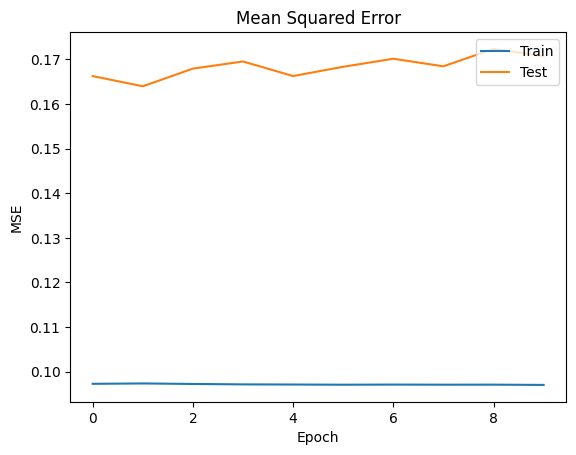

In [50]:
# Plot training and test MSE
plt.plot(train_mse)
plt.plot(test_mse)
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [51]:
train_mae = 0.21018914547118533
test_mae = 0.26912236254681093

In [52]:
print(train_mae)
print(test_mae)
print(train_mse) 
print(test_mse)

0.21018914547118533
0.26912236254681093
[0.0972913209025149, 0.0973760073455529, 0.09725923165479543, 0.09716492694645641, 0.09713311841997632, 0.09708924436313979, 0.09712315815625992, 0.09709478312436541, 0.09710281844630438, 0.09704422534881316]
[0.16625166131626193, 0.16396750277520408, 0.16792633737856047, 0.16952444119475135, 0.16626057443923348, 0.16833497536705117, 0.17014032973076926, 0.16844201420048818, 0.1723388646427423, 0.17068348213438586]
